In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [ ]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 54.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-g873zvw8
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-g873zvw8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-i8a044ch/pyfolio_d81fbd029cdd423a9dac0b731a6cf0cb
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-i8a044ch/pyfolio_d81fbd029cdd423a9dac0b731a6cf0cb
  Cloning https://github.com/AI4Finance-Foundation/El


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
%cd drive/MyDrive/Finance

/content/drive/MyDrive/Finance


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finance.config_tickers import DOW_30_TICKER
from finance.trader.data.yahoopreprocessor import YahooDownloader
from finance.trader.data.preprocessor import FeatureEngineer, data_split
from finance.trader.environments.stock_trading_envs.stock_trading import StockTradingEnv
from finance.trader.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finance.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../FinRL-Library")

import itertools

import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [ ]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [ ]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2021-01-01'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2022-12-19'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-04-01,3.717500,3.892857,3.710357,3.308904,589372000,AAPL,2
1,2009-04-01,48.779999,48.930000,47.099998,36.228401,10850100,AMGN,2
2,2009-04-01,13.340000,14.640000,13.080000,11.772779,27701800,AXP,2
3,2009-04-01,34.520000,35.599998,34.209999,26.850748,9288800,BA,2
4,2009-04-01,27.500000,29.520000,27.440001,19.820398,15308300,CAT,2


In [ ]:
df.tail()

,date,open,high,low,close,volume,tic,day
101107,2022-12-16,525.150024,525.809998,515.719971,523.700012,7108000,UNH,4
101108,2022-12-16,207.490005,208.399994,205.300003,206.889999,12472900,V,4
101109,2022-12-16,37.509998,37.570000,36.669998,37.119999,62758700,VZ,4
101110,2022-12-16,39.160000,39.459999,38.549999,39.049999,10866600,WBA,4
101111,2022-12-16,144.479996,144.720001,142.570007,142.750000,13447300,WMT,4


In [ ]:
df.shape

(96942, 8)

In [ ]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2009-04-01,3.717500,3.892857,3.710357,3.308904,589372000,AAPL,2
1,2009-04-01,48.779999,48.930000,47.099998,36.228401,10850100,AMGN,2
2,2009-04-01,13.340000,14.640000,13.080000,11.772779,27701800,AXP,2
3,2009-04-01,34.520000,35.599998,34.209999,26.850748,9288800,BA,2
4,2009-04-01,27.500000,29.520000,27.440001,19.820398,15308300,CAT,2


In [ ]:
len(df.tic.unique())

30

In [ ]:
df.tic.value_counts()

AAPL    3454
AMGN    3454
WMT     3454
WBA     3454
VZ      3454
V       3454
UNH     3454
TRV     3454
PG      3454
NKE     3454
MSFT    3454
MRK     3454
MMM     3454
MCD     3454
KO      3454
JPM     3454
JNJ     3454
INTC    3454
IBM     3454
HON     3454
HD      3454
GS      3454
DIS     3454
CVX     3454
CSCO    3454
CRM     3454
CAT     3454
BA      3454
AXP     3454
DOW      946
Name: tic, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [ ]:
#  INDICATORS = ['macd',
#                'rsi_30',
#                'cci_30',
#                'dx_30']

In [ ]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [ ]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
2665,2009-08-11,28.933876,28.999529,28.671267,15.229989,10470749,VZ,1,0.171450,16.315666,14.487740,51.655773,17.819154,2.223971,15.133523,14.859170,0.000000
21357,2012-03-02,26.900000,27.030001,26.770000,19.448036,29632800,INTC,4,0.192538,19.685913,19.095290,58.156388,69.512189,11.124532,19.295522,18.473819,9.065310
38955,2014-08-01,85.389999,86.010002,85.209999,78.576599,6759200,DIS,4,0.346756,80.586896,78.200780,52.888235,-16.217875,13.609786,78.925091,77.665178,53.163939
75995,2019-08-28,105.080002,107.209999,105.040001,96.682343,10585500,JPM,2,-1.376615,102.092762,93.987711,45.611668,-81.913026,27.092117,100.214082,100.262991,19.630556
4287,2009-10-29,26.059999,26.590000,26.000000,21.813347,13044200,UNH,3,-0.067461,21.927230,19.415939,50.887424,55.540138,2.394232,21.035964,22.201485,0.000000


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [ ]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [ ]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [ ]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)



In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  203.4039101187152
======Model training from:  2009-04-01 to  2021-01-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_1
----------------------------------------
| time/                 |              |
|    fps                | 43           |
|    iterations         | 100          |
|    time_elapsed       | 11           |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -41.3        |
|    explained_variance | -0.358       |
|    learning_rate      | 0.0007       |
|    n_updates          | 99           |
|    policy_loss        | 12.3         |
|    reward             | -0.040046293 |
|    std                | 1            |
|    value_loss         | 0.123        |
----------------------------------------
---------------------------------------
| time/         

In [23]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-01-04,2021-04-06,DDPG,0.108991,0.211768,0.362172
1,189,2021-04-06,2021-07-06,DDPG,0.227605,0.17816,0.289259
2,252,2021-07-06,2021-10-04,PPO,-0.287763,0.033905,0.026614
3,315,2021-10-04,2022-01-03,PPO,0.069464,0.138771,0.093497
4,378,2022-01-03,2022-04-04,DDPG,-0.0418,-0.124388,0.10632
5,441,2022-04-04,2022-07-06,A2C,-0.044641,-0.072519,-0.266286


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [24]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [25]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.5677461045773641


In [26]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,100000.000000,2021-04-06,NaN,2021-04-06
1,99849.391291,2021-04-07,-0.001506,2021-04-07
2,100226.450175,2021-04-08,0.003776,2021-04-08
3,100955.517481,2021-04-09,0.007274,2021-04-09
4,101151.825556,2021-04-12,0.001945,2021-04-12


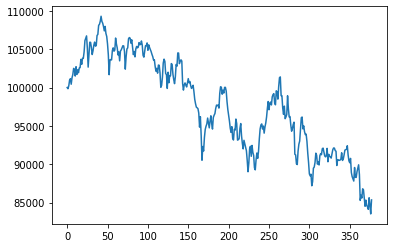

In [27]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [28]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.100233
Cumulative returns    -0.146517
Annual volatility      0.163056
Sharpe ratio          -0.567746
Calmar ratio          -0.425097
Stability              0.794318
Max drawdown          -0.235790
Omega ratio            0.911322
Sortino ratio         -0.753025
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.936891
Daily value at risk   -0.020911
dtype: float64


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.079474
Cumulative returns     0.079474
Annual volatility      0.142278
Sharpe ratio           0.610580
Calmar ratio           0.767151
Stability              0.182228
Max drawdown          -0.103597
Omega ratio            1.107807
Sortino ratio          0.886646
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.051375
Daily value at risk   -0.017581
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return          0.037486
Cumulative returns     0.037335
Annual volatility      0.134331
Sharpe ratio           0.342028
Calmar ratio           0.331049
Stability              0.066383
Max drawdown          -0.113235
Omega ratio            1.058031
Sortino ratio          0.480831
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970301
Daily value at risk   -0.016742
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (377, 8)


Start date,2021-04-06
End date,2022-10-03
Total months,18
,Backtest
Annual return,-10.023%
Cumulative returns,-14.652%
Annual volatility,16.306%
Sharpe ratio,-0.57
Calmar ratio,-0.43
Stability,0.79
Max drawdown,-23.579%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.58,2021-06-04,2022-09-30,NaT,NaN
1,3.81,2021-05-10,2021-05-12,2021-05-27,14
2,0.98,2021-04-21,2021-04-22,2021-04-29,7
3,0.98,2021-04-16,2021-04-20,2021-04-21,4
4,0.71,2021-04-12,2021-04-13,2021-04-14,3


Stress Events,mean,min,max
New Normal,-0.04%,-4.38%,2.52%


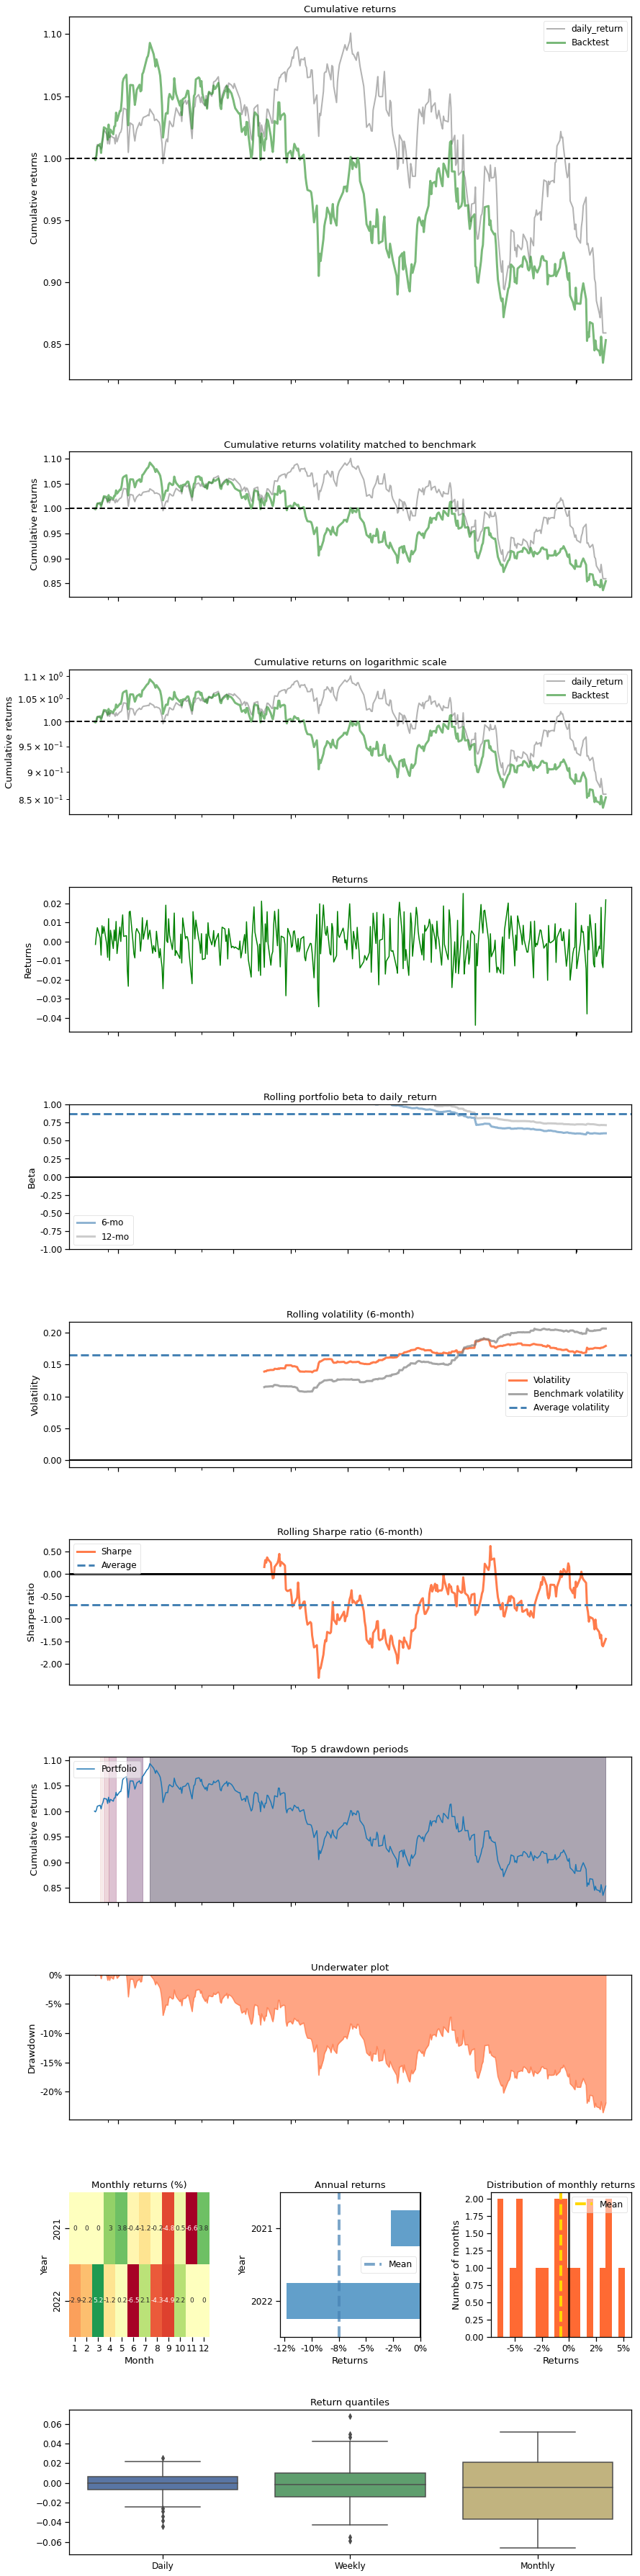

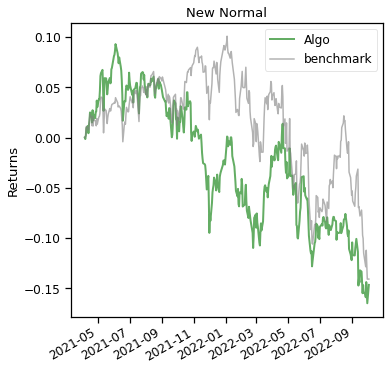

In [29]:
print("==============Compare to DJIA===========") #model
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = '^DJI', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)


Start date,2021-04-06
End date,2022-04-01
Total months,12
,Backtest
Annual return,7.947%
Cumulative returns,7.947%
Annual volatility,14.228%
Sharpe ratio,0.61
Calmar ratio,0.77
Stability,0.18
Max drawdown,-10.36%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.36,2022-01-04,2022-02-23,NaT,NaN
1,9.28,2021-10-22,2021-12-01,2022-01-04,53
2,5.23,2021-06-04,2021-06-18,2021-07-23,36
3,4.69,2021-08-27,2021-09-20,2021-09-27,22
4,3.44,2021-09-27,2021-09-30,2021-10-15,15


Stress Events,mean,min,max
New Normal,0.03%,-3.27%,2.55%


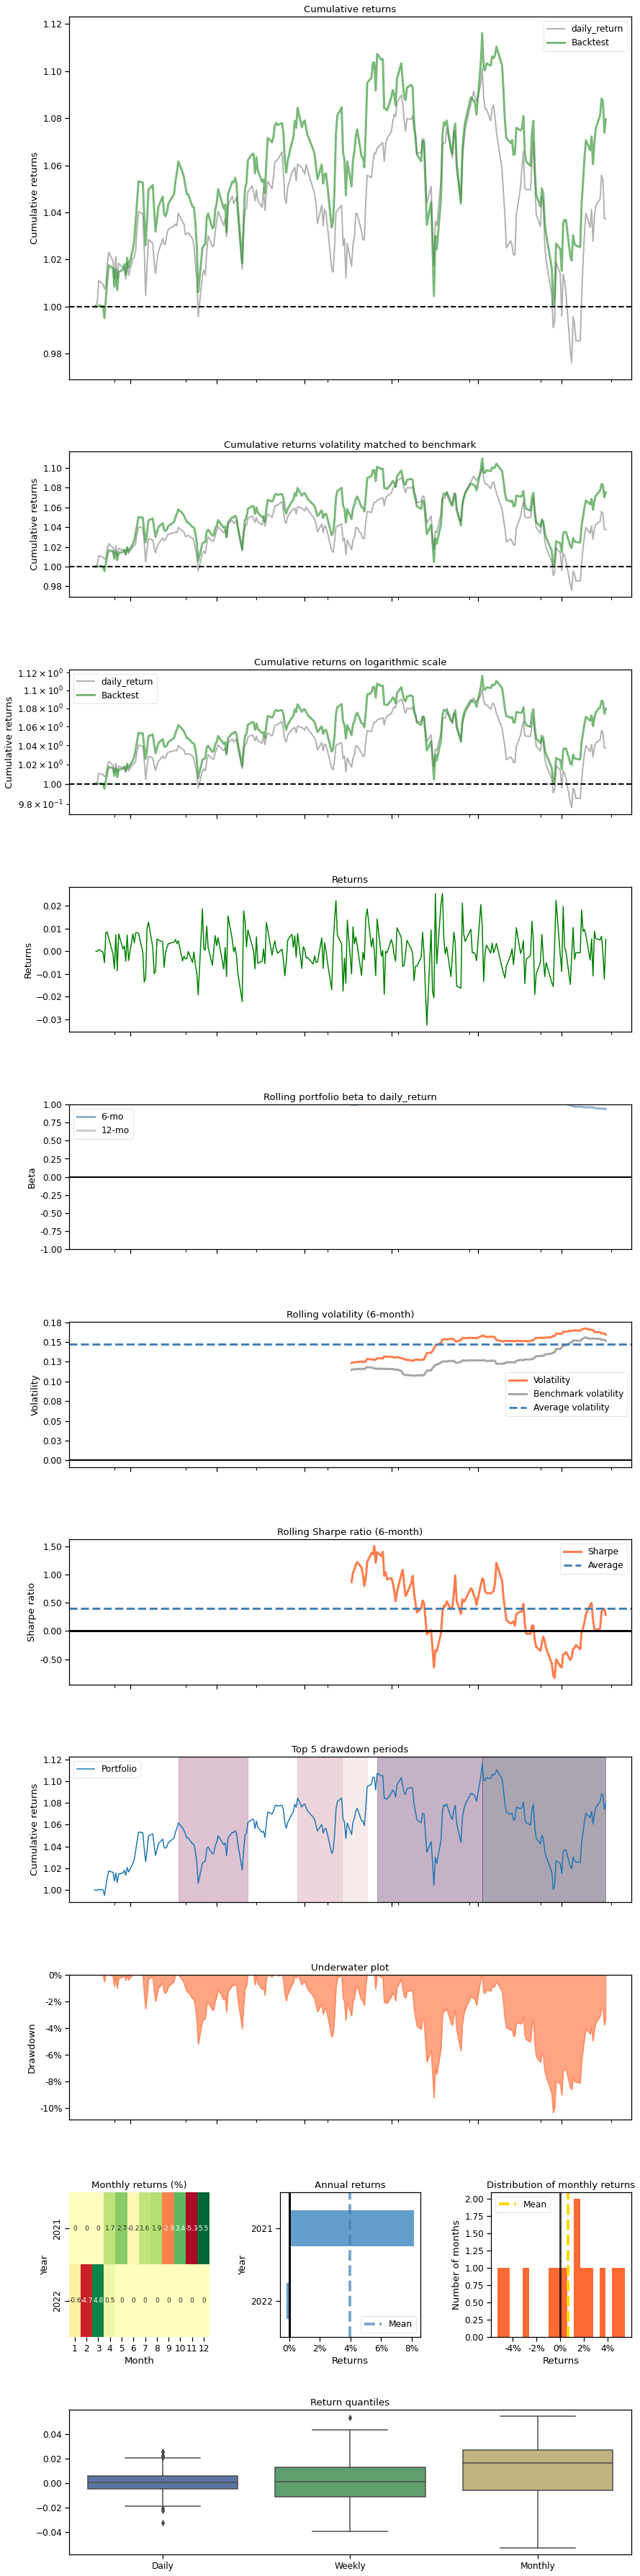

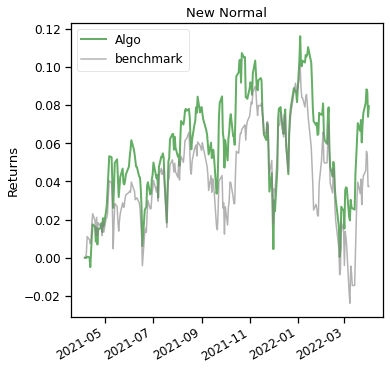

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = '^DJI', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])